In [2]:
!pip install pyqubo -q
!pip install seaborn -q
!pip install runipy -q


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import json
import os
import scipy.optimize
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import time
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def ImportImputJSON(fileName):
    columns_path = os.path.join('json', fileName, 'columns.json')
    table_path = os.path.join('json', fileName, 'Table.json')

    if not os.path.exists(columns_path) or not os.path.exists(table_path):
        print("Error: Files not found.")
        return None, None
    
    with open(columns_path) as f:
        columns = json.load(f)

    with open(table_path) as f:
        Table = json.load(f)

    return columns, Table

In [5]:
def blackbox_obj(solution, columns, Gce):
    solution_array = list(map(int, solution))

    obj = 0
    
    for i in range(len(Gce)):
        note = 0
        for j in range(len(columns)):
            note += (Gce[i][j] * solution_array[j])
        obj += ((note-1)**2)
    
    return obj

In [6]:
def time_to_solution(tau, feasibleRate, targetProbability):
    if feasibleRate == 1:
        time = tau
    else:
        time = tau * math.ceil(math.log(1-targetProbability)/math.log(1-feasibleRate))
    return time

In [7]:
def compute_expectation(counts, columns, Gce):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = blackbox_obj(bit_string, columns, Gce)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [8]:
def create_qaoa_circ(columns, Gce, theta):
    nqubits = len(Gce[0])
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    
    qc = QuantumCircuit(nqubits)

    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        for pair in list(columns):
            qc.rzz(gamma[layer_index], pair[0], pair[1])
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
        
    qc.measure_all()
    return qc

In [9]:
def get_expectation(columns, Gce, shots):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc = create_qaoa_circ(columns, Gce, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, columns, Gce)
    
    return execute_circ

In [10]:
def get_violation_count(counts, columns, Gce):
    violation_count = 0
    for items, values in counts.items():
        obj = blackbox_obj(items, columns, Gce)
        if obj == 0:
            violation_count += values
    return violation_count

In [11]:
columns, Gce = ImportImputJSON('ChengRW100')
column = []
for i, row in enumerate(Gce):
    indices = [idx for idx, val in enumerate(row) if val == 1]
    if len(indices) == 2:
        column.append((indices[0], indices[1]))

backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

In [12]:
maximum_iteration = 1
op_opt_time = time.time()
expectation = get_expectation(column, Gce, 1024)
res1 = scipy.optimize.minimize(expectation,
               [1.0, 1.0],
               method='COBYLA',
               options={'maxiter':maximum_iteration})
ed_opt_time = time.time()
opt_time1 = ed_opt_time - op_opt_time

op_time = time.time()
qc_res = create_qaoa_circ(column, Gce, res1.x)
counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()
ed_time = time.time()
tau = (ed_time-op_time)/backend.shots

feasibleRate = 1-get_violation_count(counts, column, Gce)/backend.shots

tts1 = time_to_solution(tau, feasibleRate, 0.99)

print('Number of Iteration: ', maximum_iteration)
print('Time to Optimize: ', opt_time1)
print('Parameter(theta)', res1.x)
print('Average of Object Function: ', res1.fun)
print('Time to Run Circuit Onetime: ', tau)
print('Feasible Solution Rate (function == 0): ', feasibleRate)
print('Target Probability (Goal): ', 0.99)
print('Time to Solution(TTS): ',tts1)


Number of Iteration:  1
Time to Optimize:  0.08957791328430176
Parameter(theta) [1. 1.]
Average of Object Function:  4.7626953125
Time to Run Circuit Onetime:  3.6982586607337e-05
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  3.6982586607337e-05


In [13]:
maximum_iteration = 3
op_opt_time = time.time()
expectation = get_expectation(column, Gce, 1024)
res3 = scipy.optimize.minimize(expectation,
               [1.0, 1.0],
               method='COBYLA',
               options={'maxiter':maximum_iteration})
ed_opt_time = time.time()
opt_time3 = ed_opt_time - op_opt_time

op_time = time.time()
qc_res = create_qaoa_circ(column, Gce, res3.x)
counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()
ed_time = time.time()
tau = (ed_time-op_time)/backend.shots

feasibleRate = 1-get_violation_count(counts, column, Gce)/backend.shots

tts3 = time_to_solution(tau, feasibleRate, 0.99)


print('Number of Iteration: ', maximum_iteration)
print('Time to Optimize: ', opt_time3)
print('Parameter(theta)', res3.x)
print('Average of Object Function: ', res3.fun)
print('Time to Run Circuit Onetime: ', tau)
print('Feasible Solution Rate (function == 0): ', feasibleRate)
print('Target Probability (Goal): ', 0.99)
print('Time to Solution(TTS): ',tts3)

Number of Iteration:  3
Time to Optimize:  0.21187281608581543
Parameter(theta) [1. 2.]
Average of Object Function:  4.6708984375
Time to Run Circuit Onetime:  3.534974530339241e-05
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  3.534974530339241e-05


In [14]:
maximum_iteration = 5
op_opt_time = time.time()
expectation = get_expectation(column, Gce, 1024)
res5 = scipy.optimize.minimize(expectation,
               [1.0, 1.0],
               method='COBYLA',
               options={'maxiter':maximum_iteration})
ed_opt_time = time.time()
opt_time5 = ed_opt_time - op_opt_time

op_time = time.time()
qc_res = create_qaoa_circ(column, Gce, res5.x)
counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()
ed_time = time.time()
tau = (ed_time-op_time)/backend.shots

feasibleRate = 1-get_violation_count(counts, column, Gce)/backend.shots

tts5 = time_to_solution(tau, feasibleRate, 0.99)


print('Number of Iteration: ', maximum_iteration)
print('Time to Optimize: ', opt_time5)
print('Parameter(theta)', res5.x)
print('Average of Object Function: ', res5.fun)
print('Time to Run Circuit Onetime: ', tau)
print('Feasible Solution Rate (function == 0): ', feasibleRate)
print('Target Probability (Goal): ', 0.99)
print('Time to Solution(TTS): ',tts5)

Number of Iteration:  5
Time to Optimize:  0.26894283294677734
Parameter(theta) [1. 2.]
Average of Object Function:  4.6708984375
Time to Run Circuit Onetime:  3.543263301253319e-05
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  3.543263301253319e-05


In [15]:
maximum_iteration = 10
op_opt_time = time.time()
expectation = get_expectation(column, Gce, 1024)
res10 = scipy.optimize.minimize(expectation,
               [1.0, 1.0],
               method='COBYLA',
               options={'maxiter':maximum_iteration})
ed_opt_time = time.time()
opt_time10 = ed_opt_time - op_opt_time

op_time = time.time()
qc_res = create_qaoa_circ(column, Gce, res10.x)
counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()
ed_time = time.time()
tau = (ed_time-op_time)/backend.shots

feasibleRate = 1-get_violation_count(counts, column, Gce)/backend.shots

tts10 = time_to_solution(tau, feasibleRate, 0.99)


print('Number of Iteration: ', maximum_iteration)
print('Time to Optimize: ', opt_time10)
print('Parameter(theta)', res10.x)
print('Average of Object Function: ', res10.fun)
print('Time to Run Circuit Onetime: ', tau)
print('Feasible Solution Rate (function == 0): ', feasibleRate)
print('Target Probability (Goal): ', 0.99)
print('Time to Solution(TTS): ',tts10)

Number of Iteration:  10
Time to Optimize:  0.545536994934082
Parameter(theta) [1.24855872 1.97319395]
Average of Object Function:  4.2353515625
Time to Run Circuit Onetime:  2.624327316880226e-05
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  2.624327316880226e-05


In [16]:
maximum_iteration = 20
op_opt_time = time.time()
expectation = get_expectation(column, Gce, 1024)
res20 = scipy.optimize.minimize(expectation,
               [1.0, 1.0],
               method='COBYLA',
               options={'maxiter':maximum_iteration})
ed_opt_time = time.time()
opt_time20 = ed_opt_time - op_opt_time

op_time = time.time()
qc_res = create_qaoa_circ(column, Gce, res20.x)
counts = backend.run(qc_res, seed_simulator=10, shots=1024).result().get_counts()
ed_time = time.time()
tau = (ed_time-op_time)/backend.shots

feasibleRate = 1-get_violation_count(counts, column, Gce)/backend.shots

tts20 = time_to_solution(tau, feasibleRate, 0.99)


print('Number of Iteration: ', maximum_iteration)
print('Time to Optimize: ', opt_time20)
print('Parameter(theta)', res20.x)
print('Average of Object Function: ', res20.fun)
print('Time to Run Circuit Onetime: ', tau)
print('Feasible Solution Rate (function == 0): ', feasibleRate)
print('Target Probability (Goal): ', 0.99)
print('Time to Solution(TTS): ',tts20)
res20

Number of Iteration:  20
Time to Optimize:  0.8277630805969238
Parameter(theta) [1.1665886  1.79837853]
Average of Object Function:  4.0498046875
Time to Run Circuit Onetime:  2.5239307433366776e-05
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  2.5239307433366776e-05


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.0498046875
       x: [ 1.167e+00  1.798e+00]
    nfev: 20
   maxcv: 0.0

In [17]:
tts_list = []
opt_time_list = []
for i in range(6):
    op_opt_time = time.time()
    expectation = get_expectation(column, Gce, 4**i)
    res = scipy.optimize.minimize(expectation,
                [1.0, 1.0],
                method='COBYLA')
    ed_opt_time = time.time()
    opt_time = ed_opt_time - op_opt_time

    op_time = time.time()
    qc_res = create_qaoa_circ(column, Gce, res.x)
    counts = backend.run(qc_res, seed_simulator=10, shots = 4**i).result().get_counts()
    ed_time = time.time()
    tau = (ed_time-op_time)/4**i

    feasibleRate = 1-get_violation_count(counts, column, Gce)/4**i 

    tts = time_to_solution(tau, feasibleRate, 0.99)
    tts_list.append(tts)
    opt_time_list.append(opt_time)

    print('Time to Optimize: ', opt_time)
    print('Parameter(theta)', res.x)
    print('Average of Object Function: ', res.fun)
    print('Time to Run Circuit Onetime: ', tau)
    print('Feasible Solution Rate (function == 0): ', feasibleRate)
    print('Target Probability (Goal): ', 0.99)
    print('Time to Solution(TTS): ',tts)
    print()

Time to Optimize:  1.5410480499267578
Parameter(theta) [1.18393737 1.68027752]
Average of Object Function:  4.01171875
Time to Run Circuit Onetime:  0.01743793487548828
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  0.01743793487548828

Time to Optimize:  1.3654968738555908
Parameter(theta) [1.18393737 1.68027752]
Average of Object Function:  4.01171875
Time to Run Circuit Onetime:  0.00338822603225708
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  0.00338822603225708

Time to Optimize:  1.3126111030578613
Parameter(theta) [1.18393737 1.68027752]
Average of Object Function:  4.01171875
Time to Run Circuit Onetime:  0.0007462501525878906
Feasible Solution Rate (function == 0):  1.0
Target Probability (Goal):  0.99
Time to Solution(TTS):  0.0007462501525878906

Time to Optimize:  1.5109500885009766
Parameter(theta) [1.18393737 1.68027752]
Average of Object Function:  4.01171875
T

In [18]:
print('Optimize Time(1):  ', opt_time1)
print('Optimize Time(3):  ', opt_time3)
print('Optimize Time(5):  ', opt_time5)
print('Optimize Time(10): ', opt_time10)
print('Optimize Time(20): ', opt_time20)
print()
print('Time to Solution(1):  ', tts1)
print('Time to Solution(3):  ', tts3)
print('Time to Solution(5):  ', tts5)
print('Time to Solution(10): ', tts10)
print('Time to Solution(20): ', tts20)
print()
print('Optimized Parameters(1):  ', res1.x)
print('Optimized Parameters(3):  ', res3.x)
print('Optimized Parameters(5):  ', res5.x)
print('Optimized Parameters(10): ', res10.x)
print('Optimized Parameters(20): ', res20.x)
print()
print('Average Objective Function(1):  ', res1.fun)
print('Average Objective Function(3):  ', res3.fun)
print('Average Objective Function(5):  ', res5.fun)
print('Average Objective Function(10): ', res10.fun)
print('Average Objective Function(20): ', res20.fun)

Optimize Time(1):   0.08957791328430176
Optimize Time(3):   0.21187281608581543
Optimize Time(5):   0.26894283294677734
Optimize Time(10):  0.545536994934082
Optimize Time(20):  0.8277630805969238

Optimized Parameters(1):   [1. 1.]
Optimized Parameters(3):   [1. 2.]
Optimized Parameters(5):   [1. 2.]
Optimized Parameters(10):  [1.24855872 1.97319395]
Optimized Parameters(20):  [1.1665886  1.79837853]

Time to Solution(1):   3.6982586607337e-05
Time to Solution(3):   3.534974530339241e-05
Time to Solution(5):   3.543263301253319e-05
Time to Solution(10):  2.624327316880226e-05
Time to Solution(20):  2.5239307433366776e-05

Average Objective Function(1):   4.7626953125
Average Objective Function(3):   4.6708984375
Average Objective Function(5):   4.6708984375
Average Objective Function(10):  4.2353515625
Average Objective Function(20):  4.0498046875


In [19]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.01171875
       x: [ 1.184e+00  1.680e+00]
    nfev: 39
   maxcv: 0.0

In [20]:
print(counts)

{'0110011010011001': 1, '1001101001101001': 1, '1010010101101001': 1, '0101101001100101': 3, '1010010110101001': 2, '1010100110101001': 4, '1001100110101001': 4, '0101011010011001': 2, '1010101010100101': 1, '0110010101011001': 4, '1010011001101010': 2, '0101100101101001': 2, '1010010101011001': 3, '1010010101101010': 2, '0101100101101110': 1, '1010101010011001': 1, '0101101010100101': 3, '0101101010011001': 3, '1001011010100110': 6, '1010010101100101': 1, '0110010101100101': 2, '0100100101010101': 2, '0101011010101000': 1, '1001011010101001': 3, '0110100101100110': 1, '0101011010101010': 4, '0100011001010110': 1, '1010100100011010': 1, '0101010101011010': 1, '0101100101011001': 1, '0101011001010101': 3, '0100011001100110': 1, '0001101010010110': 1, '0101010101100101': 4, '0110010110011001': 3, '0110101010010110': 4, '0101010110011001': 2, '0101100101010101': 2, '1001010101101001': 2, '0101011001101001': 4, '0110100110010101': 2, '0110010110010110': 5, '0101100110100110': 3, '011001100

In [21]:
print(column)
print(Gce)

[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15)]
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]


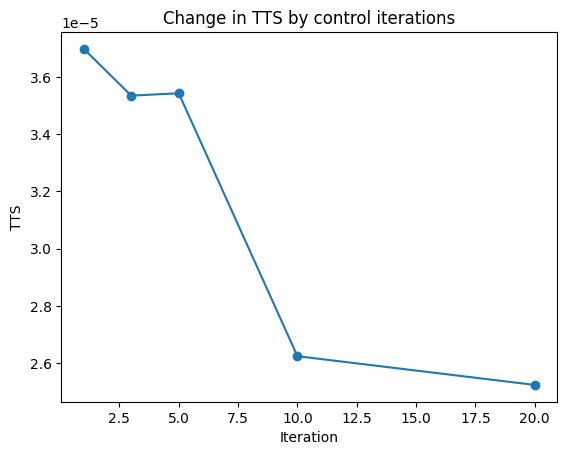

In [22]:
iter = [1, 3, 5, 10, 20]
tts = [tts1, tts3, tts5, tts10, tts20]

plt.plot(iter, tts, marker='o')
plt.xlabel('Iteration')
plt.ylabel('TTS')
plt.title('Change in TTS by control iterations')
plt.grid(False)

plt.show()

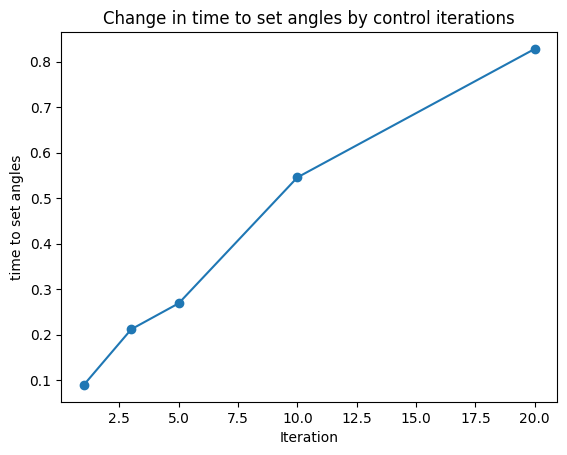

In [23]:
iter = [1, 3, 5, 10, 20]
optimize = [opt_time1, opt_time3, opt_time5, opt_time10, opt_time20]

plt.plot(iter, optimize, marker='o')
plt.xlabel('Iteration')
plt.ylabel('time to set angles')
plt.title('Change in time to set angles by control iterations')
plt.grid(False)

plt.show()

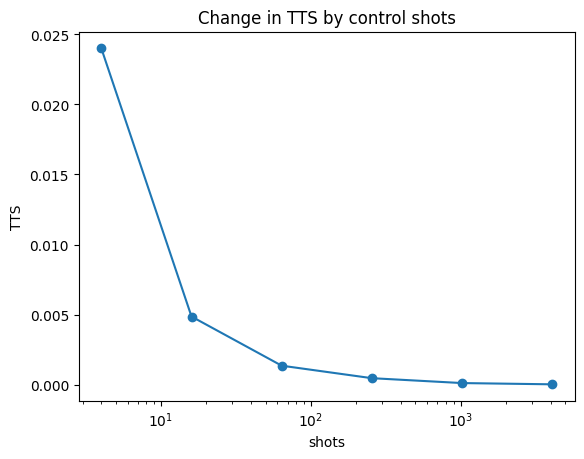

In [169]:
shots = [4, 16, 64, 256, 1024, 4096]
tts = [tts_list[0], tts_list[1], tts_list[2], tts_list[3], tts_list[4], tts_list[5]]

plt.plot(shots, tts, marker='o')
plt.xscale('log')
plt.xlabel('shots')
plt.ylabel('TTS')
plt.title('Change in TTS by control shots')
plt.grid(False)

plt.show()

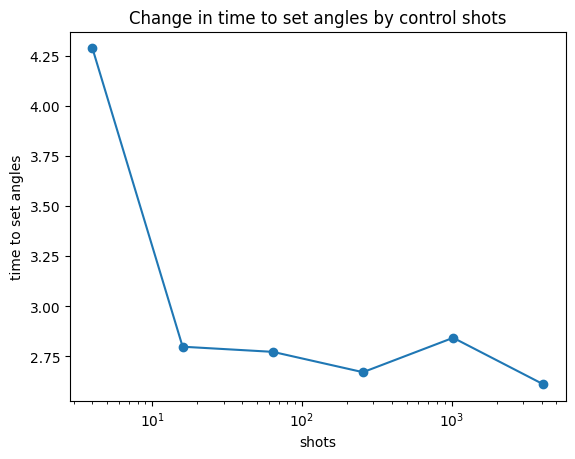

In [170]:
shots = [4, 16, 64, 256, 1024, 4096]
opt_time = [opt_time_list[0], opt_time_list[1], opt_time_list[2], opt_time_list[3], opt_time_list[4], opt_time_list[5]]

plt.plot(shots, opt_time, marker='o')
plt.xscale('log')
plt.xlabel('shots')
plt.ylabel('time to set angles')
plt.title('Change in time to set angles by control shots')
plt.grid(False)

plt.show()